In [2]:
!pip install kapre > kapre.log

In [1]:
"""
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
directory = '/content/drive/MyDrive/Curruira'
!cp /content/drive/MyDrive/Curruira/models.py .
!ls
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive', force_remount=True)\ndirectory = '/content/drive/MyDrive/Curruira'\n!cp /content/drive/MyDrive/Curruira/models.py .\n!ls\n"

In [3]:
directory = "."

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
import models
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold

In [6]:
# Open the pickled file in binary mode and read the pickled data
with open(os.path.join(directory,'mel_spectrograms.pkl'), 'rb') as f:
    mel_spectrograms = pickle.load(f)

with open(os.path.join(directory,'labels_segments.pkl'), 'rb') as f:
    labels_segments = pickle.load(f)

with open(os.path.join(directory,'labels.pkl'), 'rb') as f:
    labels = pickle.load(f) # A eh amostra impactada e B nao impactada

with open(os.path.join(directory,'labels_records.pkl'), 'rb') as f:
    labels_records = pickle.load(f)

with open(os.path.join(directory,'wav_records.pkl'), 'rb') as f:
    wav_records = pickle.load(f)

## Embeddings extraction with Biophony + Kapre

2024-08-21 16:10:20.437924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 16:10:20.479960: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 44100, 1)          3         
 on)                                                             
                                                                 
 gaussian_noise (GaussianNo  (None, 44100, 1)          0         
 ise)                                                            
                                                                 
 stft (STFT)                 (None, 682, 257, 1)       0         
                                                                 
 magnitude (Magnitude)       (None, 682, 257, 1)       0         
                                                                 
 apply_filterbank (ApplyFil  (None, 682, 40, 1)        0         
 terbank)                                                        
                                                        

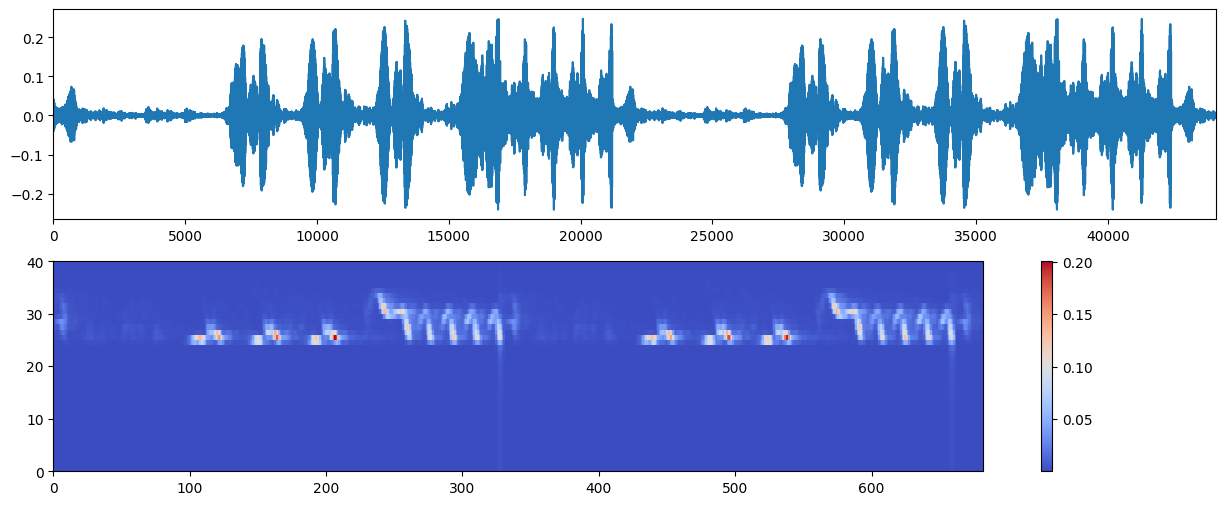

In [7]:
kapre_model = models.build_kapre_model(summary=True)

x = wav_records[1]
x = x[np.newaxis,:,np.newaxis]
print(x.shape)
y = kapre_model.predict(x)
print(np.min(y[0]), np.max(y[0]))

fig = plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(x[0,:])
plt.xlim([0,len(x[0,:])])
plt.subplot(2,1,2)
plt.pcolormesh(y[0,:,:,0], cmap='coolwarm')
plt.colorbar()
plt.show()

## extracting mel spectrogram with kapre to find de scale factor

In [7]:
# y = kapre_model.predict(wav_records[:,:,np.newaxis])
# scale_kapre = np.max(np.abs(y))
# print(scale_kapre)

In [8]:
"""
!mkdir biophony_model
!mkdir ./biophony_model/resources/
!cp /content/drive/MyDrive/Curruira/biophony_model/resources/cmi_mbam01.json ./biophony_model/resources/cmi_mbam01.json
!cp /content/drive/MyDrive/Curruira/biophony_model/resources/cmi_mbam01.h5 ./biophony_model/resources/cmi_mbam01.h5
"""

'\n!mkdir biophony_model\n!mkdir ./biophony_model/resources/\n!cp /content/drive/MyDrive/Curruira/biophony_model/resources/cmi_mbam01.json ./biophony_model/resources/cmi_mbam01.json\n!cp /content/drive/MyDrive/Curruira/biophony_model/resources/cmi_mbam01.h5 ./biophony_model/resources/cmi_mbam01.h5\n'

In [8]:
biophony_model = models.build_biophony_model(summary=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 40, 682, 16)       256       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 20, 227, 16)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 20, 227, 16)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 225, 32)       4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 9, 75, 32)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 9, 75, 32)        

In [9]:
model = models.build_model(kapre_model, biophony_model, summary=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 40, 682, 1)        3         
                                                                 
 sequential_1 (Sequential)   (None, 512)               3547456   
                                                                 
 drop1 (Dropout)             (None, 512)               0         
                                                                 
 den1 (Dense)                (None, 512)               262656    
                                                                 
 drop2 (Dropout)             (None, 512)               0         
                                                                 
 den2 (Dense)                (None, 2)                 1026      
                                                                 
Total params: 3811141 (14.54 MB)
Trainable params: 381

In [10]:
# reshape to batches for the input model.
X_train_normal = wav_records.reshape(wav_records.shape[0], wav_records.shape[1], 1)

# converting lables to categorical
labels = 1*(labels=='amostraA') # A eh amostra impactada e B nao impactada
cat_labels = tf.keras.utils.to_categorical(labels)

In [11]:
print(labels[:5])
cat_labels[:5]

[1 1 1 0 1]


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [12]:
histories = []
y_pred = []
y_test = []

kf = KFold(n_splits=5, shuffle=True, random_state=1234)
for i, (train_index, test_index) in enumerate(kf.split(X_train_normal)):
    print(f'model {i} \n')
    X_train, X_test = X_train_normal[train_index], X_train_normal[test_index]
    y_train = cat_labels[train_index]
    y_test.append(labels[test_index])

    checkpoint_filepath = os.path.join(directory,'kfold_model_'+str(i)+'.h5')
    if os.path.exists(checkpoint_filepath):
        os.remove(checkpoint_filepath) # Remove any existing checkpoint file

    my_callbacks = [EarlyStopping(patience=5, monitor="val_accuracy", restore_best_weights=True),
                    ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_accuracy", save_best_only = True)]

    model = models.build_model(kapre_model, biophony_model)
    histories.append(model.fit(X_train, y_train,
                             batch_size=32,
                             epochs=50,
                             callbacks=my_callbacks,
                             validation_split=0.2))

    print('\n predict \n')
    # model.load_weights(checkpoint_filepath)
    y_pred.append(1*(model.predict(X_test) >= 0.5))

model 0 

Epoch 1/50
18/18 [==============================] - 4s 174ms/step - loss: 0.6437 - accuracy: 0.6532 - val_loss: 0.5887 - val_accuracy: 0.7063
Epoch 2/50
 1/18 [>.............................] - ETA: 2s - loss: 0.6315 - accuracy: 0.6875

/home/ufamlas/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 3s 160ms/step - loss: 0.5748 - accuracy: 0.7025 - val_loss: 0.5340 - val_accuracy: 0.7483
Epoch 3/50
18/18 [==============================] - 3s 156ms/step - loss: 0.4810 - accuracy: 0.7694 - val_loss: 0.4406 - val_accuracy: 0.8042
Epoch 4/50
18/18 [==============================] - 3s 155ms/step - loss: 0.4080 - accuracy: 0.8151 - val_loss: 0.3811 - val_accuracy: 0.7972
Epoch 5/50
18/18 [==============================] - 3s 158ms/step - loss: 0.3813 - accuracy: 0.8345 - val_loss: 0.3587 - val_accuracy: 0.8392
Epoch 6/50
18/18 [==============================] - 3s 157ms/step - loss: 0.3045 - accuracy: 0.8697 - val_loss: 0.2707 - val_accuracy: 0.8811
Epoch 7/50
18/18 [==============================] - 3s 157ms/step - loss: 0.2522 - accuracy: 0.8961 - val_loss: 0.2707 - val_accuracy: 0.8881
Epoch 8/50
18/18 [==============================] - 3s 154ms/step - loss: 0.2370 - accuracy: 0.8979 - val_loss: 0.2057 - val_accuracy: 0.8881
Epoch 9/50
18/18 

In [13]:
plt.figure(figsize=(300,36))
i = 1
for history in histories:
    epochs = len(history.history['accuracy'])
    plt.subplot(1,5,i)
    plt.plot(range(epochs), history.history['val_accuracy'], 'r', label='val_accuracy')
    plt.plot(range(epochs), history.history['accuracy'], 'b', label='accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1.01])
    plt.legend()
    plt.title(f'fold {i}')

    i += 1

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       432
           1       0.98      0.99      0.98       457

    accuracy                           0.98       889
   macro avg       0.98      0.98      0.98       889
weighted avg       0.98      0.98      0.98       889



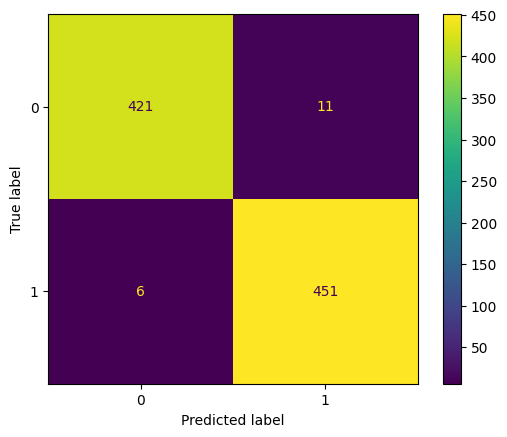

In [14]:
y_pred = np.concatenate(y_pred, axis=0)
y_pred = np.argmax(y_pred, axis=-1)
y_test = np.concatenate(y_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## final model for SHAP

In [15]:
checkpoint_filepath = os.path.join(directory,'kfold_model_SHAP.h5')
if os.path.exists(checkpoint_filepath):
    os.remove(checkpoint_filepath) # Remove any existing checkpoint file

my_callbacks = [EarlyStopping(patience=5, monitor="val_accuracy", restore_best_weights=True),
                ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_accuracy", save_best_only = True)]

final_model = models.build_model(kapre_model, biophony_model)
final_history = final_model.fit(X_train_normal, cat_labels,
                                batch_size=32,
                                epochs=50,
                                callbacks=my_callbacks,
                                validation_split=0.5)

#final_history.save(checkpoint_filepath+'6')

# final_model.save(checkpoint_filepath)

Epoch 1/50
14/14 [==============================] - 4s 214ms/step - loss: 0.2918 - accuracy: 0.8761 - val_loss: 0.1029 - val_accuracy: 0.9775
Epoch 2/50
 1/14 [=>............................] - ETA: 1s - loss: 0.0789 - accuracy: 1.0000

/home/ufamlas/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 3s 203ms/step - loss: 0.0969 - accuracy: 0.9707 - val_loss: 0.0732 - val_accuracy: 0.9798
Epoch 3/50
14/14 [==============================] - 3s 197ms/step - loss: 0.0526 - accuracy: 0.9842 - val_loss: 0.1108 - val_accuracy: 0.9573
Epoch 4/50
14/14 [==============================] - 3s 197ms/step - loss: 0.0640 - accuracy: 0.9842 - val_loss: 0.0563 - val_accuracy: 0.9843
Epoch 5/50
14/14 [==============================] - 3s 196ms/step - loss: 0.0488 - accuracy: 0.9865 - val_loss: 0.0454 - val_accuracy: 0.9865
Epoch 6/50
14/14 [==============================] - 3s 196ms/step - loss: 0.0340 - accuracy: 0.9932 - val_loss: 0.0583 - val_accuracy: 0.9820
Epoch 7/50
14/14 [==============================] - 3s 193ms/step - loss: 0.0648 - accuracy: 0.9797 - val_loss: 0.0468 - val_accuracy: 0.9865
Epoch 8/50
14/14 [==============================] - 3s 191ms/step - loss: 0.0259 - accuracy: 0.9977 - val_loss: 0.0471 - val_accuracy: 0.9865
Epoch 9/50
14/14 

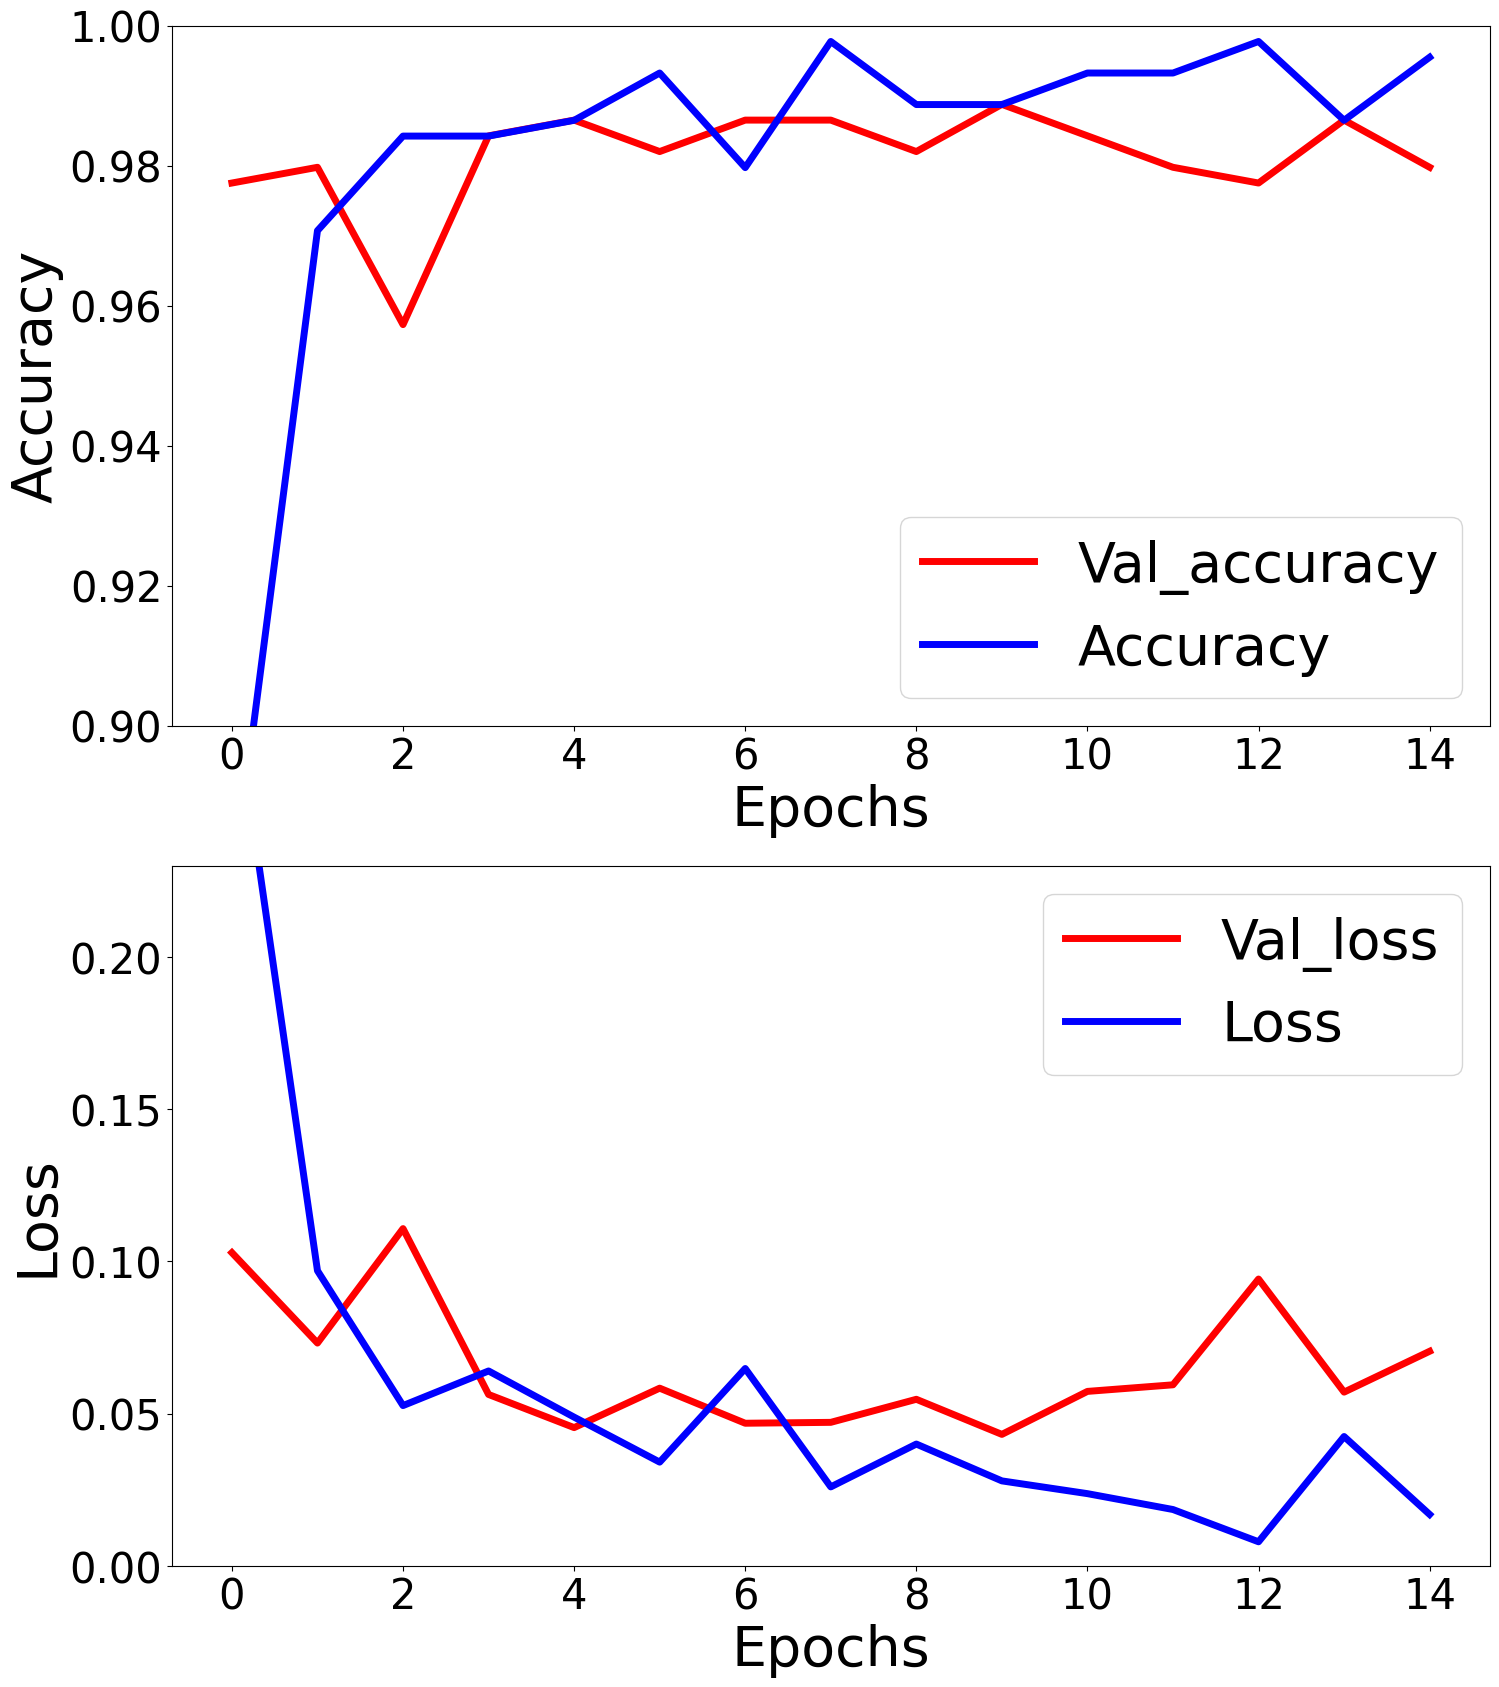

In [16]:
epochs = len(final_history.history['accuracy'])

plt.figure(figsize=(17,20))#mude aqui para aumentar a imagem
plt.subplot(2,1,1)
plt.plot(range(epochs), final_history.history['val_accuracy'], 'r', lw=5, label='Val_accuracy')
plt.plot(range(epochs), final_history.history['accuracy'], 'b', lw=5, label='Accuracy')
plt.xlabel('Epochs',fontsize=40)
plt.ylabel('Accuracy',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim([0.90, 1.0])
plt.legend(fontsize=40)
plt.subplot(2,1,2)
plt.plot(range(epochs), final_history.history['val_loss'], 'r', lw=5, label='Val_loss')
plt.plot(range(epochs), final_history.history['loss'], 'b', lw=5, label='Loss')
plt.xlabel('Epochs',fontsize=40)
plt.ylabel('Loss',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim([0, 0.23])
plt.legend(fontsize=40)

In [17]:
import pickle

pickle.dump(final_history, open("KapreHistory.pkl",'wb'))